In [ ]:
import requests
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
import re

def extract_text_from_url(url):
    try:
        response = requests.get(url, timeout=10)
        if response.status_code != 200:
            return None

        soup = BeautifulSoup(response.text, 'html.parser')

        for selector in [
            "header", "footer", "nav", "aside", "script", "style",
            ".sidebar", ".inner-header-large", ".inner-header-small",
            "#sidebar1", ".footer-table", ".nav-social", ".page-header-social"
        ]:
            for tag in soup.select(selector):
                tag.decompose()

        content_parts = []

        banner_div = soup.select_one(".forcefullwidth_wrapper_tp_banner")
        if banner_div:
            content_parts.append(banner_div.get_text(separator='\n', strip=True))

        main_div = soup.select_one("div#main") or soup.select_one("section.entry-content")
        if not main_div:
            all_divs = soup.find_all("div")
            main_div = max(all_divs, key=lambda d: len(d.get_text(strip=True)), default=None)

        if main_div:
            content_parts.append(main_div.get_text(separator='\n', strip=True))

        if content_parts:
            combined_text = "\n\n".join(content_parts)
            cleaned_text = re.sub(r'\n\s*\n+', '\n\n', combined_text)
            cleaned_text = re.sub(r'[ \t]+', ' ', cleaned_text)

            # Filter out based on unwanted content
            UNWANTED_PHRASES = [
            """Leave a Reply
You must be
logged in
to post a comment.""",

            """Read more...""",
            
            """Uh Oh. Something is missing. Try double checking things."""
            ]
            if any(phrase in cleaned_text for phrase in UNWANTED_PHRASES):
                return None

            return cleaned_text if cleaned_text.strip() else None

        return None

    except Exception as e:
        print(f"Error scraping {url}: {e}")
        return None


In [22]:
import requests
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
import re

# URL of the sitemap index
sitemap_url = 'https://www.niagarawater.com/wp-sitemap.xml'

# Store results
successful_scrapes = []
failed_scrapes = []

# # Function to extract and clean main content
# def extract_text_from_url(url):
#     try:
#         response = requests.get(url, timeout=10)
#         if response.status_code != 200:
#             return None

#         soup = BeautifulSoup(response.text, 'html.parser')

#         # Remove header/footer/nav/sidebar/etc.
#         for selector in ["header", "footer", "nav", "aside", "script", "style", ".sidebar", ".inner-header-large", ".inner-header-small", "#sidebar1", ".footer-table", ".nav-social", ".page-header-social"]:
#             for tag in soup.select(selector):
#                 tag.decompose()

#         # Target likely content areas
#         main_div = soup.select_one("div#main") or soup.select_one("section.entry-content")
#         if not main_div:
#             all_divs = soup.find_all("div")
#             main_div = max(all_divs, key=lambda d: len(d.get_text(strip=True)), default=None)

#         if main_div:
#             raw_text = main_div.get_text(separator='\n', strip=True)
#             cleaned_text = re.sub(r'\n\s*\n+', '\n\n', raw_text)
#             cleaned_text = re.sub(r'[ \t]+', ' ', cleaned_text)
#             return cleaned_text if cleaned_text.strip() else None

#         return None

#     except Exception as e:
#         print(f"Error scraping {url}: {e}")
#         return None

# Recursively parse all nested sitemaps and URLs
def parse_sitemap(url):
    try:
        response = requests.get(url, timeout=10)
        if response.status_code != 200:
            print(f"Failed to load sitemap: {url}")
            return []

        root = ET.fromstring(response.content)
        namespace = {'ns': 'http://www.sitemaps.org/schemas/sitemap/0.9'}
        loc_elements = root.findall('.//ns:loc', namespaces=namespace)
        urls = [loc.text for loc in loc_elements]

        if root.tag.endswith('sitemapindex'):
            all_urls = []
            for sub_url in urls:
                all_urls.extend(parse_sitemap(sub_url))
            return all_urls
        return urls

    except Exception as e:
        print(f"Error parsing sitemap {url}: {e}")
        return []

# Run the scraper
all_urls = parse_sitemap(sitemap_url)

for url in all_urls:
    print(f"Scraping: {url}")
    text = extract_text_from_url(url)
    if text:
        successful_scrapes.append({'url': url, 'text': text})
    else:
        failed_scrapes.append(url)

# Save results
with open('successful_scrapes_cleaned.txt', 'w', encoding='utf-8') as f:
    for entry in successful_scrapes:
        f.write(f"URL: {entry['url']}\n\n{entry['text']}\n\n{'='*80}\n")

with open('failed_scrapes.txt', 'w', encoding='utf-8') as f:
    for url in failed_scrapes:
        f.write(f"{url}\n")

print(f"\n✅ Total Successful Scrapes: {len(successful_scrapes)}")
print(f"❌ Total Failed Scrapes: {len(failed_scrapes)}")


Scraping: https://www.niagarawater.com/
Scraping: https://www.niagarawater.com/beverage-offerings/
Scraping: https://www.niagarawater.com/about-us/
Scraping: https://www.niagarawater.com/about-us/history-of-niagara/
Scraping: https://www.niagarawater.com/about-us/keys-to-our-success/
Scraping: https://www.niagarawater.com/about-us/awards-recognition/
Scraping: https://www.niagarawater.com/quality/
Scraping: https://www.niagarawater.com/quality/the-pure-difference/
Scraping: https://www.niagarawater.com/quality/water-quality/
Scraping: https://www.niagarawater.com/sustainability/
Scraping: https://www.niagarawater.com/sustainability/packaging-efficiency/
Scraping: https://www.niagarawater.com/sustainability/energy/
Scraping: https://www.niagarawater.com/community/
Scraping: https://www.niagarawater.com/niagaracares/
Scraping: https://www.niagarawater.com/community/the-andrew-d-peykoff-sr-scholarship-program/
Scraping: https://www.niagarawater.com/community/disaster-relief/
Scraping: htt

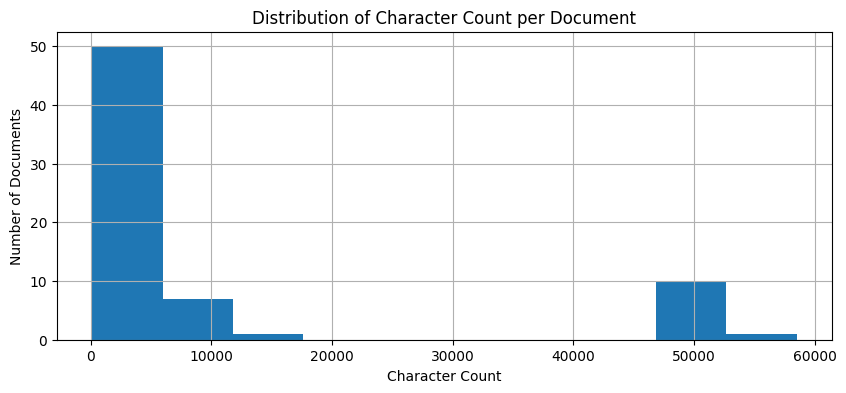

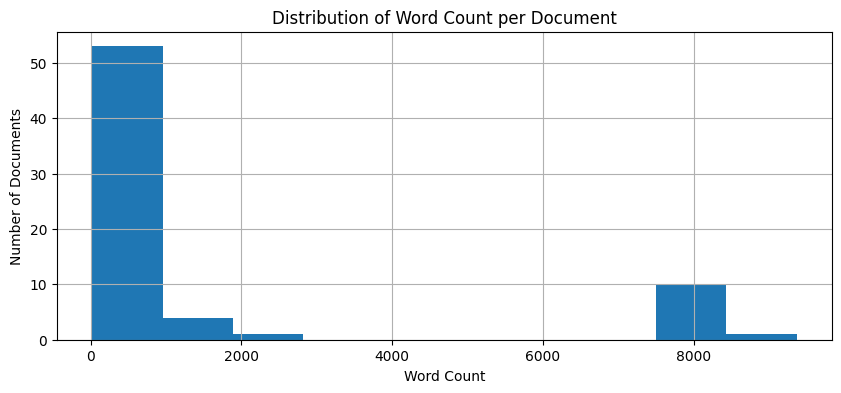

In [23]:
import pandas as pd

# Analyze character and word counts
data = []
for entry in successful_scrapes:
    text = entry['text']
    char_count = len(text)
    word_count = len(text.split())
    data.append({
        "url": entry['url'],
        "char_count": char_count,
        "word_count": word_count
    })

# Convert to DataFrame
df = pd.DataFrame(data)

# Describe the distribution
summary_stats = df.describe()

import matplotlib.pyplot as plt

# Plot histograms for both character and word counts
plt.figure(figsize=(10, 4))
plt.hist(df["char_count"], bins=10)
plt.title("Distribution of Character Count per Document")
plt.xlabel("Character Count")
plt.ylabel("Number of Documents")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.hist(df["word_count"], bins=10)
plt.title("Distribution of Word Count per Document")
plt.xlabel("Word Count")
plt.ylabel("Number of Documents")
plt.grid(True)
plt.show()



In [24]:
summary_stats

,char_count,word_count
count,69.000000,69.000000
mean,10492.695652,1649.449275
std,17420.263286,2770.207576
min,115.000000,18.000000
25%,1256.000000,200.000000
50%,3286.000000,468.000000
75%,6023.000000,897.000000
max,58517.000000,9367.000000


In [25]:
from langchain.schema import Document

docs = [
    Document(page_content=entry['text'], metadata={"source": entry['url']})
    for entry in successful_scrapes
]


In [64]:
import os 
import tempfile
import pinecone
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langsmith import traceable
from writerai import Writer
from typing import List
from langchain.document_loaders import SitemapLoader
from pinecone import Pinecone, ServerlessSpec
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Pinecone as LangChainPinecone

# Initialize Pinecone instance
pc = Pinecone(api_key=os.environ.get("PINECONE_API_KEY"))

# Create an index if it does not exist
index_name = "niagara-cleaned-docs"
if index_name not in pc.list_indexes().names():
    pc.create_index(
        name=index_name, 
        dimension=3072,  # Adjust based on your embedding size
        metric="cosine",  # You can choose cosine or euclidean
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        )
    )

# Initialize the embedding model
embd = OpenAIEmbeddings(model="text-embedding-3-large")

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=4000, chunk_overlap=300
    )

doc_splits = text_splitter.split_documents(docs)

# Store vectors in Pinecone (using the LangChain wrapper)
vectorstore = LangChainPinecone.from_documents(doc_splits, embd, index_name=index_name, batch_size=10)

USER_AGENT environment variable not set, consider setting it to identify your requests.
C:\Users\pramo\AppData\Local\Temp\ipykernel_6812\3844928282.py:30: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embd = OpenAIEmbeddings(model="text-embedding-3-large")


In [66]:
embd = OpenAIEmbeddings(model="text-embedding-3-large")
text = "Types of water produced by Niagara Bottling and their differences"
embeddings = embd.embed_query(text)
print(embeddings)

[-0.006735735085167984, -0.012648213613360418, -0.018683159662730105, 0.022602133378918157, -0.029092932024747782, -0.050048552289714845, 0.01956764974746364, -0.054539039552525787, -0.020792329615849012, 0.007361682107792556, 0.06379216888530137, -0.0023098806775012463, -0.016750888844144992, -0.011784134394105358, -0.04139415161174849, -0.014097416727299254, -0.027636924668101075, -0.009688571995079623, 0.021853716972471193, 0.007511364737156149, 0.01641069906049315, 0.01386608830771535, -0.03284861509181779, 0.013804854779957368, 0.020833151346805953, 0.0002659849988438814, -0.028249263670971192, -0.02196257740521656, 0.0040618521028437755, 0.01956764974746364, 0.010736352728931205, -0.009518478034576273, 0.039298590144045326, 0.027160659343517527, -0.023064788355440822, 0.044224522863128016, 0.04925931228966579, 0.026031233285106918, 0.06139724309019359, 0.0009907993921247323, -0.008395855287550966, -0.003034482467301307, 0.007824338015637792, -0.002462965661049418, -0.051436520944